In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [19]:
dict_margin = {'AD': 3000, 'BP': 3000, 'C': 2000, 'CD': 3000, 'CL': 18000, 'EC': 3800, 'ES': 13000, 'FDAX': 40000, 'GC': 15000, 'HG': 10000, 'NG': 5000, 'NQ': 23000,
               'RTY': 8000, 'S': 4000, 'VX': 26000, 'VXX': 900, 'YM': 15000}

In [3]:
def compute_np_dd(daily_profit: np.array) -> tuple[np.array, np.array, np.array]:
    '''
    Function to compute NP, equity peak and DD as functions of time.

    Args:
        daily_profit: Array containing the daily profit.
    
    Returns:
        cum_profit: Array containing cumulated profit over time.
        max_equity: Array containing equity peak over time.
        dd: Array containing drawdown over time.
    '''
    cum_profit = daily_profit.cumsum()
    max_equity = pd.Series(cum_profit).cummax().values
    dd = cum_profit - max_equity
    #
    return cum_profit, max_equity, dd

def correlation_classic(data_1: np.array, data_2: np.array) -> float:
    '''
    Function to compute the correlation between two strategies as lag-0 cross-correlation.

    Args:
        data_1: Array containing two columns: the first one are the dates, and the second one the P/L.
        data_2: Array containing two columns: the first one are the dates, and the second one the P/L.

    Returns:
        corr: Correlation coefficient.
    '''
    # get common dates and slice data
    _, idx_1, idx_2 = np.intersect1d(data_1['date'].values, data_2['date'].values, return_indices = True)
    data_1 = data_1.loc[idx_1, 'daily_profit'].astype(float)
    data_2 = data_2.loc[idx_2, 'daily_profit'].astype(float)
    n = data_1.shape[0]
    # mean values and standard deviations
    mu_1 = data_1.mean()
    mu_2 = data_2.mean()
    sigma_1 = data_1.std()
    sigma_2 = data_2.std()
    # compute correlation
    corr = 1/(n*sigma_1*sigma_2)*np.sum((data_1 - mu_1)*(data_2 - mu_2))
    #
    return corr

def _read_strats():
    '''
    Function to import strategies results.
    '''
    dict_results = {}
    for strat in list_strat:#self.dict_strat.keys():
        instrument = strat.split('_')[0]
        # read data
        with open(f'../reports/{strat}') as f:
            data = f.readlines()
        data = np.array([i.split(' ') for i in data])
        # get strategy parameters
        dates = pd.to_datetime(data[:, 0], format = '%d/%m/%Y')
        daily_profit = data[:, 1].astype(float)
        curr_contract = data[:, 2].astype(float)*dict_strat[strat]
        n_trades = data[:, 5].astype(int)
        # build dataframe
        df = pd.DataFrame({'date': dates, 'daily_profit': daily_profit, 'curr_contract': curr_contract, 'n_trades': n_trades})
        df['margin'] = dict_margin[instrument]*df['curr_contract'].abs()
        dict_results[strat] = df
    return dict_results

def portfolio_performance(dict_strat_vol: dict, date_start: str = None, date_end: str = None) -> pd.DataFrame:
        '''
        Function to compute the performance of a portfolio.
        
        Args:
            dict_strat_vol: Dictionary containing the number of contracts used for each strategy in the portfolio.
            date_start: First date to be considered.
            date_end: Last date to be considered.

        Returns:
            df_portfolio: Dataframe containing the portfolio performance.
        '''
        #
        df_portfolio = {instr: [] for instr in np.unique([strat.split('_')[0] for strat in dict_strat_vol.keys()])}
        for i in range(len(dict_strat_vol)):
            # get strategy features
            strategy = list(dict_strat_vol.keys())[i]
            instrument = strategy.split('_')[0]
            n_contracts = dict_strat_vol[strategy]
            #
            df_temp = dict_results[strategy]
            # keep relevant dates
            df_temp = df_temp[(df_temp['date'] >= date_start) & (df_temp['date'] < date_end)].reset_index(drop = True)
            # adjust profit and margins by number of contracts
            df_temp['daily_profit'] *= n_contracts
            df_temp['margin'] *= n_contracts*np.sign(df_temp['curr_contract'])
            # combine portfolio strategies
            df_temp.index = df_temp['date']
            df_portfolio[instrument].append(df_temp)
        df_portfolio = {instr: performance for instr, performance in df_portfolio.items() if len(performance) > 0}
        # combine performances for each instrument
        for instr in df_portfolio.keys():
            df_portfolio[instr] = pd.concat(df_portfolio[instr], axis = 1)
            if type(df_portfolio[instr]['daily_profit']) == pd.DataFrame:
                df_portfolio[instr]['daily_profit'] = df_portfolio[instr]['daily_profit'].sum(axis = 1)
            if type(df_portfolio[instr]['margin']) == pd.DataFrame:
                df_portfolio[instr]['margin'] = df_portfolio[instr]['margin'].sum(axis = 1)
            df_portfolio[instr] = df_portfolio[instr].loc[:, ~df_portfolio[instr].columns.duplicated()][['date', 'daily_profit', 'margin']]
            df_portfolio[instr]['margin'] = abs(df_portfolio[instr]['margin'])
        # compute aggregated performance
        df_portfolio = [value for value in df_portfolio.values()]
        df_portfolio = pd.concat(df_portfolio, axis = 1)
        if type(df_portfolio['daily_profit']) == pd.DataFrame:
            df_portfolio['daily_profit'] = df_portfolio['daily_profit'].sum(axis = 1)
        if type(df_portfolio['margin']) == pd.DataFrame:
            df_portfolio['margin'] = df_portfolio['margin'].sum(axis = 1)
        df_portfolio = df_portfolio.loc[:, ~df_portfolio.columns.duplicated()][['date', 'daily_profit', 'margin']]
        # add portfolio cumulative statistics
        df_portfolio['cum_profit'], df_portfolio['max_equity'], df_portfolio['dd'] = compute_np_dd(df_portfolio['daily_profit'])
        #
        return df_portfolio.reset_index(drop = True).sort_values(by = 'date')

In [162]:
list_strat = np.random.choice([i for i in os.listdir('../reports/') if ('TSLA' not in i) and ('GOOG' not in i)], 3)
dict_results = {}
for strat in list_strat:
    df = pd.read_csv('../reports/' + strat, delimiter = ' ', header = None)
    df['margin'] = dict_margin[strat.split('_')[0]]*df[2]
    df = df[[0, 1, 2, 'margin']]
    df.columns = ['date', 'daily_profit', 'curr_contract', 'margin']
    df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
    df['cum_profit'], _, df['dd'] = compute_np_dd(df['daily_profit'])
    dict_results[strat] = df
first_date = max([i['date'].min() for i in dict_results.values()])
for strat in dict_results.keys():
    dict_results[strat] = dict_results[strat][dict_results[strat]['date'] >= first_date].reset_index(drop = True)
df_port = portfolio_performance({strat: 1 for strat in dict_results.keys()}, date_start = first_date, date_end = '2025-01-01')

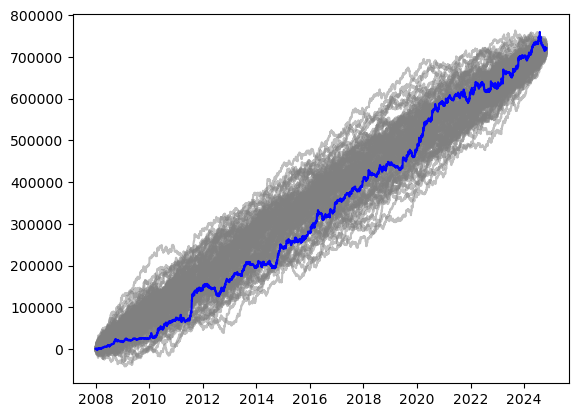

In [163]:
plt.figure()
list_mc = []
for i in range(100):
    df_temp = df_port.copy()
    shuffle_idx = np.random.choice(range(df_temp.shape[0]), df_temp.shape[0], replace = False)
    df_temp['daily_profit'] = df_temp.loc[shuffle_idx, 'daily_profit'].values
    df_temp['daily_profit'] *= (1 + np.random.rand(df_temp.shape[0])*0.2 - 0.1)
    df_temp['cum_profit'], _, df_temp['dd'] = compute_np_dd(df_temp['daily_profit'])
    list_mc.append(df_temp)
    plt.plot(df_temp['date'], df_temp['cum_profit'], c = 'gray', alpha = 0.5)
plt.plot(df_port['date'], df_port['cum_profit'], c = 'b')

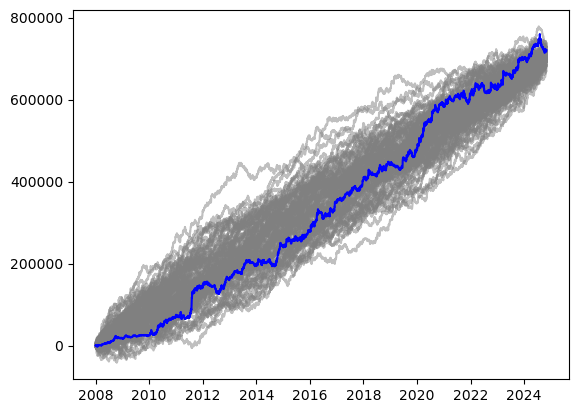

In [217]:
plt.figure()
list_mc = []
for i in range(100):
    dict_results = {}
    for strat in list_strat:
        df = pd.read_csv('../reports/' + strat, delimiter = ' ', header = None)
        df['margin'] = dict_margin[strat.split('_')[0]]*df[2]
        df = df[[0, 1, 2, 'margin']]
        df.columns = ['date', 'daily_profit', 'curr_contract', 'margin']
        df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
        shuffle_idx = np.random.choice(range(df.shape[0]), df.shape[0], replace = False)
        df['daily_profit'] = df.loc[shuffle_idx, 'daily_profit'].values
        df['daily_profit'] *= (1 + np.random.rand(df.shape[0])*0.2 - 0.1)
        dict_results[strat] = df
    first_date = max([i['date'].min() for i in dict_results.values()])
    for strat in dict_results.keys():
        dict_results[strat] = dict_results[strat][dict_results[strat]['date'] >= first_date].reset_index(drop = True)
    df_temp = portfolio_performance({strat: 1 for strat in dict_results.keys()}, date_start = first_date, date_end = '2025-01-01')
    df_temp['cum_profit'], _, df_temp['dd'] = compute_np_dd(df_temp['daily_profit'])
    list_mc.append(df_temp)
    plt.plot(df_temp['date'], df_temp['cum_profit'], c = 'gray', alpha = 0.5)
plt.plot(df_port['date'], df_port['cum_profit'], c = 'b')

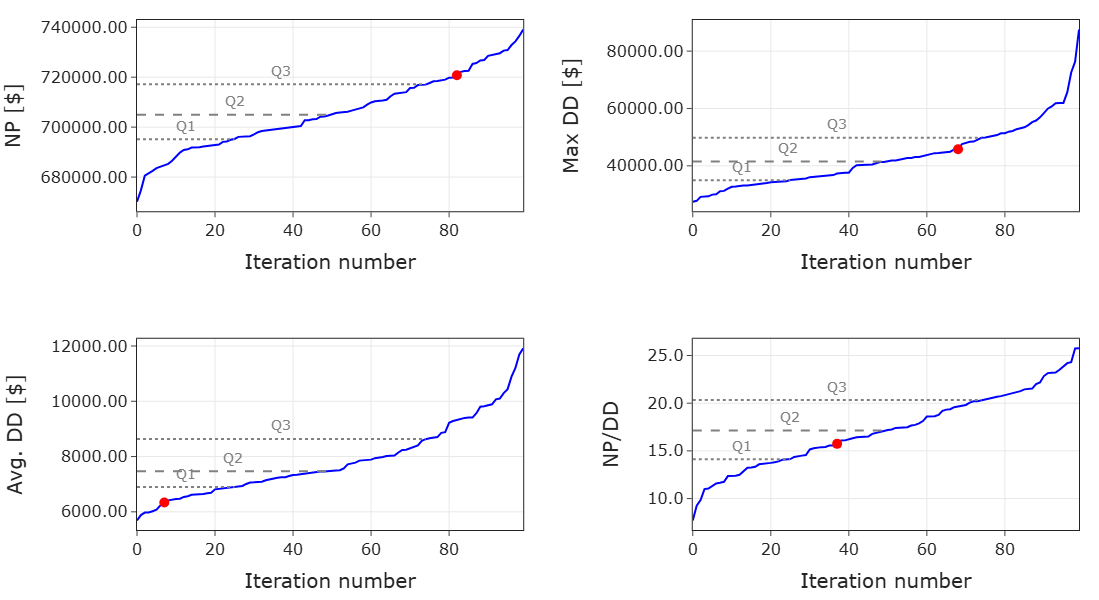

In [218]:
figure = make_subplots(rows = 2, cols = 2, vertical_spacing = 0.25, horizontal_spacing = 0.18)
figure.update_layout(go.Layout(margin = dict(l = 20, r = 20, t = 20, b = 20), template = 'simple_white', showlegend = False,
                               xaxis1 = {'showgrid': True, 'showline': True, 'mirror': True, 'titlefont': {'size': 20}, 'tickfont': {'size': 16}, 'title': 'Iteration number'},
                               yaxis1 = {'showgrid': True, 'showline': True, 'mirror': True, 'titlefont': {'size': 20}, 'tickfont': {'size': 16},
                                        'tickformat': f'.{2}f', 'title': 'NP [$]'},
                               xaxis2 = {'showgrid': True, 'showline': True, 'mirror': True, 'titlefont': {'size': 20}, 'tickfont': {'size': 16}, 'title': 'Iteration number'},
                               yaxis2 = {'showgrid': True, 'showline': True, 'mirror': True, 'titlefont': {'size': 20}, 'tickfont': {'size': 16},
                                        'tickformat': f'.{2}f', 'title': 'Max DD [$]'},
                               xaxis3 = {'showgrid': True, 'showline': True, 'mirror': True, 'titlefont': {'size': 20}, 'tickfont': {'size': 16}, 'title': 'Iteration number'},
                               yaxis3 = {'showgrid': True, 'showline': True, 'mirror': True, 'titlefont': {'size': 20}, 'tickfont': {'size': 16},
                                        'tickformat': f'.{2}f', 'title': 'Avg. DD [$]'},
                               xaxis4 = {'showgrid': True, 'showline': True, 'mirror': True, 'titlefont': {'size': 20}, 'tickfont': {'size': 16}, 'title': 'Iteration number'},
                               yaxis4 = {'showgrid': True, 'showline': True, 'mirror': True, 'titlefont': {'size': 20}, 'tickfont': {'size': 16},
                                        'tickformat': f'.{1}f', 'title': 'NP/DD'},
                               font = {'size': 28}, autosize = False, width = 1200, height = 600, hovermode = 'closest'))
#
list_np_mc = np.sort([i['cum_profit'].values[-1] for i in list_mc])
figure.add_trace(go.Scatter(x = np.arange(len(list_mc)), y = np.sort([i['cum_profit'].values[-1] for i in list_mc]), mode = 'lines', line_color = 'blue'), row = 1, col = 1)
figure.add_trace(go.Scatter(x = [np.argmin(abs(list_np_mc - df_port['cum_profit'].values[-1]))],
                            y = [df_port['cum_profit'].values[-1]], marker_color = 'red', marker_size = 10), row = 1, col = 1)
figure.add_trace(go.Scatter(x = [0, np.argmin(abs(list_np_mc - np.quantile(list_np_mc, 0.5)))],
                            y = [np.quantile(list_np_mc, 0.5)]*2, mode = 'lines', line_color = 'grey', line_dash = 'dash'), row = 1, col = 1)
figure.add_annotation(x = np.argmin(abs(list_np_mc - np.quantile(list_np_mc, 0.5)))/2, y = np.quantile(list_np_mc, 0.5), text = 'Q2', showarrow = False, yshift = 14,
                      font = {'size': 14, 'color': 'gray'}, row = 1, col = 1)
figure.add_trace(go.Scatter(x = [0, np.argmin(abs(list_np_mc - np.quantile(list_np_mc, 0.25)))],
                            y = [np.quantile(list_np_mc, 0.25)]*2, mode = 'lines', line_color = 'grey', line_dash = 'dot'), row = 1, col = 1)
figure.add_annotation(x = np.argmin(abs(list_np_mc - np.quantile(list_np_mc, 0.25)))/2, y = np.quantile(list_np_mc, 0.25), text = 'Q1', showarrow = False, yshift = 14,
                      font = {'size': 14, 'color': 'gray'}, row = 1, col = 1)
figure.add_trace(go.Scatter(x = [0, np.argmin(abs(list_np_mc - np.quantile(list_np_mc, 0.75)))],
                            y = [np.quantile(list_np_mc, 0.75)]*2, mode = 'lines', line_color = 'grey', line_dash = 'dot'), row = 1, col = 1)
figure.add_annotation(x = np.argmin(abs(list_np_mc - np.quantile(list_np_mc, 0.75)))/2, y = np.quantile(list_np_mc, 0.75), text = 'Q3', showarrow = False, yshift = 14,
                      font = {'size': 14, 'color': 'gray'}, row = 1, col = 1)
#
list_dd_mc = np.sort([-i['dd'].min() for i in list_mc])
figure.add_trace(go.Scatter(x = np.arange(len(list_mc)), y = np.sort([-i['dd'].min() for i in list_mc]), mode = 'lines', line_color = 'blue'), row = 1, col = 2)
figure.add_trace(go.Scatter(x = [np.argmin(abs(list_dd_mc - -df_port['dd'].min()))],
                            y = [-df_port['dd'].min()], marker_color = 'red', marker_size = 10), row = 1, col = 2)
figure.add_trace(go.Scatter(x = [0, np.argmin(abs(list_dd_mc - np.quantile(list_dd_mc, 0.5)))],
                            y = [np.quantile(list_dd_mc, 0.5)]*2, mode = 'lines', line_color = 'grey', line_dash = 'dash'), row = 1, col = 2)
figure.add_annotation(x = np.argmin(abs(list_dd_mc - np.quantile(list_dd_mc, 0.5)))/2, y = np.quantile(list_dd_mc, 0.5), text = 'Q2', showarrow = False, yshift = 14,
                      font = {'size': 14, 'color': 'gray'}, row = 1, col = 2)
figure.add_trace(go.Scatter(x = [0, np.argmin(abs(list_dd_mc - np.quantile(list_dd_mc, 0.25)))],
                            y = [np.quantile(list_dd_mc, 0.25)]*2, mode = 'lines', line_color = 'grey', line_dash = 'dot'), row = 1, col = 2)
figure.add_annotation(x = np.argmin(abs(list_dd_mc - np.quantile(list_dd_mc, 0.25)))/2, y = np.quantile(list_dd_mc, 0.25), text = 'Q1', showarrow = False, yshift = 14,
                      font = {'size': 14, 'color': 'gray'}, row = 1, col = 2)
figure.add_trace(go.Scatter(x = [0, np.argmin(abs(list_dd_mc - np.quantile(list_dd_mc, 0.75)))],
                            y = [np.quantile(list_dd_mc, 0.75)]*2, mode = 'lines', line_color = 'grey', line_dash = 'dot'), row = 1, col = 2)
figure.add_annotation(x = np.argmin(abs(list_dd_mc - np.quantile(list_dd_mc, 0.75)))/2, y = np.quantile(list_dd_mc, 0.75), text = 'Q3', showarrow = False, yshift = 14,
                      font = {'size': 14, 'color': 'gray'}, row = 1, col = 2)
#
list_dd_avg_mc = np.sort([-i['dd'].mean() for i in list_mc])
figure.add_trace(go.Scatter(x = np.arange(len(list_mc)), y = np.sort([-i['dd'].mean() for i in list_mc]), mode = 'lines', line_color = 'blue'), row = 2, col = 1)
figure.add_trace(go.Scatter(x = [np.argmin(abs(list_dd_avg_mc - -df_port['dd'].mean()))],
                            y = [-df_port['dd'].mean()], marker_color = 'red', marker_size = 10), row = 2, col = 1)
figure.add_trace(go.Scatter(x = [0, np.argmin(abs(list_dd_avg_mc - np.quantile(list_dd_avg_mc, 0.5)))],
                            y = [np.quantile(list_dd_avg_mc, 0.5)]*2, mode = 'lines', line_color = 'grey', line_dash = 'dash'), row = 2, col = 1)
figure.add_annotation(x = np.argmin(abs(list_dd_avg_mc - np.quantile(list_dd_avg_mc, 0.5)))/2, y = np.quantile(list_dd_avg_mc, 0.5), text = 'Q2', showarrow = False, yshift = 14,
                      font = {'size': 14, 'color': 'gray'}, row = 2, col = 1)
figure.add_trace(go.Scatter(x = [0, np.argmin(abs(list_dd_avg_mc - np.quantile(list_dd_avg_mc, 0.25)))],
                            y = [np.quantile(list_dd_avg_mc, 0.25)]*2, mode = 'lines', line_color = 'grey', line_dash = 'dot'), row = 2, col = 1)
figure.add_annotation(x = np.argmin(abs(list_dd_avg_mc - np.quantile(list_dd_avg_mc, 0.25)))/2, y = np.quantile(list_dd_avg_mc, 0.25), text = 'Q1', showarrow = False, yshift = 14,
                      font = {'size': 14, 'color': 'gray'}, row = 2, col = 1)
figure.add_trace(go.Scatter(x = [0, np.argmin(abs(list_dd_avg_mc - np.quantile(list_dd_avg_mc, 0.75)))],
                            y = [np.quantile(list_dd_avg_mc, 0.75)]*2, mode = 'lines', line_color = 'grey', line_dash = 'dot'), row = 2, col = 1)
figure.add_annotation(x = np.argmin(abs(list_dd_avg_mc - np.quantile(list_dd_avg_mc, 0.75)))/2, y = np.quantile(list_dd_avg_mc, 0.75), text = 'Q3', showarrow = False, yshift = 14,
                      font = {'size': 14, 'color': 'gray'}, row = 2, col = 1)
#
list_np_dd_mc = np.sort([-i['cum_profit'].values[-1]/i['dd'].min() for i in list_mc])
figure.add_trace(go.Scatter(x = np.arange(len(list_mc)), y = list_np_dd_mc, mode = 'lines', line_color = 'blue'), row = 2, col = 2)
figure.add_trace(go.Scatter(x = [np.argmin(abs(list_np_dd_mc - -df_port['cum_profit'].values[-1]/df_port['dd'].min()))],
                            y = [-df_port['cum_profit'].values[-1]/df_port['dd'].min()], marker_color = 'red', marker_size = 10), row = 2, col = 2)
figure.add_trace(go.Scatter(x = [0, np.argmin(abs(list_np_dd_mc - np.quantile(list_np_dd_mc, 0.5)))],
                            y = [np.quantile(list_np_dd_mc, 0.5)]*2, mode = 'lines', line_color = 'grey', line_dash = 'dash'), row = 2, col = 2)
figure.add_annotation(x = np.argmin(abs(list_np_dd_mc - np.quantile(list_np_dd_mc, 0.5)))/2, y = np.quantile(list_np_dd_mc, 0.5), text = 'Q2', showarrow = False, yshift = 14,
                      font = {'size': 14, 'color': 'gray'}, row = 2, col = 2)
figure.add_trace(go.Scatter(x = [0, np.argmin(abs(list_np_dd_mc - np.quantile(list_np_dd_mc, 0.25)))],
                            y = [np.quantile(list_np_dd_mc, 0.25)]*2, mode = 'lines', line_color = 'grey', line_dash = 'dot'), row = 2, col = 2)
figure.add_annotation(x = np.argmin(abs(list_np_dd_mc - np.quantile(list_np_dd_mc, 0.25)))/2, y = np.quantile(list_np_dd_mc, 0.25), text = 'Q1', showarrow = False, yshift = 14,
                      font = {'size': 14, 'color': 'gray'}, row = 2, col = 2)
figure.add_trace(go.Scatter(x = [0, np.argmin(abs(list_np_dd_mc - np.quantile(list_np_dd_mc, 0.75)))],
                            y = [np.quantile(list_np_dd_mc, 0.75)]*2, mode = 'lines', line_color = 'grey', line_dash = 'dot'), row = 2, col = 2)
figure.add_annotation(x = np.argmin(abs(list_np_dd_mc - np.quantile(list_np_dd_mc, 0.75)))/2, y = np.quantile(list_np_dd_mc, 0.75), text = 'Q3', showarrow = False, yshift = 14,
                      font = {'size': 14, 'color': 'gray'}, row = 2, col = 2)